In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
from collections import namedtuple
from pathlib import Path
from multiprocessing import Pool
from sklearn.metrics import confusion_matrix

(400, 400, 3)

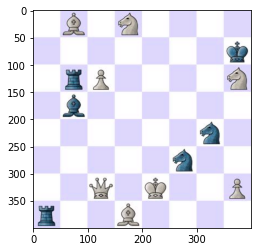

In [2]:
im = cv2.imread('./1B1N4-7k-1rP4N-1b6-6n1-5n2-2Q1K2P-r2B4.jpeg')
label='1B1N4-7k-1rP4N-1b6-6n1-5n2-2Q1K2P-r2B4'
plt.imshow(im)
im.shape

# Machinery

## split a chess board into its squares

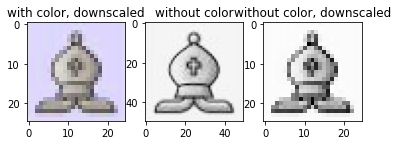

In [3]:
def split_chessboard(board_image):
    '''Split a single image of a chess board into its respective squares.
    
    Take in chess board (n*8 x m*8 x 3 / n*8 x m*8 color / greyscale image) and output an ndarray of
    the pieces (8 x 8 x n x m x 3 / 8 x 8 x n x m) such that result[0, 1] is the 0,1th tile of the chess board.
    (0 is the column, 1 is the row)
    
    Handles both greyscale and color.
    '''
    assert board_image.shape[0] % 8 == 0, 'the width of the image is not divisible by 8'
    assert board_image.shape[1] % 8 == 0, 'the height of the image is not divisible by 8'
    # shape to reshape the image to
    reshape = [8, board_image.shape[0]//8, 8, board_image.shape[1]//8]
    # order of axes to re-arrange to
    transpose = [0, 2, 1, 3]
    # handle colour
    if len(board_image.shape) == 3:
        reshape.append(3)  # needs the extra dimension with 3 color channels
        transpose.append(len(transpose))  # dimension stays at the end
    return board_image.reshape(*reshape).transpose(transpose)

plt.subplot(131)
plt.title('with color, downscaled')
plt.imshow(split_chessboard(cv2.resize(im, (200, 200)))[0, 1])
plt.subplot(132)
plt.title('without color')
plt.imshow(split_chessboard(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))[0, 1], cmap='Greys_r')
plt.subplot(133)
plt.title('without color, downscaled')
plt.imshow(split_chessboard(cv2.cvtColor(cv2.resize(im, (200, 200)), cv2.COLOR_BGR2GRAY))[0, 1], cmap='Greys_r')
plt.show()

## Get the label
given a row, column and string of the chess boards positioning (FEN description) of the chess board, return the piece code.

Overview of the representation:
the first part of the string denotes 

In [4]:
def get_position(fen, row, column, delim='-'):
    ''' returns a string representing the piece. one or Three parts:
    1. B/W = black or white square
    2. B/W = black or white piece, no more characters if no piece.
    3. piece key or doesnt exist if blank. (same encoding as white pieces in FEN)
    
    pawn = "P"
    knight = "N"
    bishop = "B"
    rook = "R"
    queen = "Q"
    king = "K"
    '''
    assert isinstance(column, int), f'column must be an integer. Got {column}'
    assert isinstance(row, int), f'row must be an integer. Got {row}'
    square_color = 'W' if ((column + row) % 2) == 0 else 'B'
    col_pos = 0
    
    # col_pos always points to the correct position for the current character. 
    for char in fen.split(delim)[row]:
        if char in '12345678':  # empty spaces (cannot be larger then 8)
            if col_pos == column:  # this was the correct position
                return square_color
            col_pos += int(char)  # the next position is offset by this many
            continue  # this position is completed, move on to the next one
        if column == col_pos:
            piece_color = 'B' if char.islower() else 'W'
            return square_color + piece_color + char.upper()
        col_pos += 1
    return square_color

## Cleanly split a board into its squares and their images, positions and labels

In [5]:
Tile = namedtuple('Tile', ['image', 'row', 'column', 'background_color', 'piece_color', 'piece_label'])
def make_data(board, name):
    out = []
    ims = split_chessboard(board)
    for row in range(8):
        for column in range(8):
            lab = get_position(name, row, column)
            has_piece = len(lab) > 1
            piece_color = lab[1] if has_piece else ''
            piece_label = lab[2] if has_piece else ''
            out.append(Tile(ims[row, column], row, column, lab[0], piece_color, piece_label))
    return out

## Load the whole dataset

In [6]:
%%time
def load_dataset(test=False, count=None, idxset=None, return_indexes=False, color=True, dsize=None):
    '''Loads a chunk of the dataset.
    
    Default loads the entire test/train dataset. (this will likely crash the machine)
    
    :param test: flag - load the test or train dataset (default train)
    :param count: int - number of examples to load
    :param idxset: set[int] - legal indexes to load
    :param return_indexes: flag - if true, returns the indexes as the last element of the returned tuple
    :param color: flag - load the images in color
    :param dsize: (int, int) - load the images and resize them to this size
        Both ints must be divisible by 8
    :return: Images, Labels [, indexes]
    '''
    max_idx = max(idxset) if idxset is not None else count - 1 if count is not None else None
    # make sure index requested is legal
    if test:
        assert count is None or max_idx <= 20000, (f'There are only 20000 images in the test set.'
                                  f' Highest index requested was {max_idx}')
    else:
        assert count is None or max_idx <= 80000, (f'There are only 80000 images in the train set.'
                                  f' Highest index requested was {max_idx}')
    # make sure destination size is legal
    if dsize is not None:
        assert np.all((np.array(dsize) % 8) == 0), f'Must be divisible by 8 on all resize dimensions. Got {dsize}'
    
    # construct the paths to images
    p = Path('dataset')
    if test:
        p /= 'test'
    else:
        p /= 'train'
    assert p.exists(), 'the dataset could not be found. Expected location: ' + str(p.parent.resolve())
    dirs = np.array(list(sorted(p.iterdir())))
    
    # draw sample
    if count is not None:
        if idxset is not None:
            idxset = np.array(list(idxset))
            if count <= len(idxset):
                idxs = np.random.choice(idxset, count, replace=False)
            else:
                idxs = idxset
        else:
            idxs = np.random.choice(dirs.shape[0], count, replace=False)
        sample = dirs[idxs]
    else:
        sample = dirs
        idxs = np.arange(dirs.shape[0])
    
    # load all images
    Y = []
    X = []
    for imagepath in sample:
        Y.append(imagepath.stem)  # FEN string
        
        # set the correct flag to handle grey/color images
        flag = cv2.IMREAD_UNCHANGED
        if color:
            flag = cv2.IMREAD_COLOR
        else:
            flag = cv2.IMREAD_GRAYSCALE
        # load the file
        image = cv2.imread(str(imagepath), flag)
        
        # resize the image if necessary
        if dsize is not None:
            X.append(cv2.resize(image, dsize))
        else:
            X.append(image)
    
    if return_indexes:
        return X, Y, idxs
    else:
        return X, Y

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 5.96 µs


## Generator to batch-load the dataset

This allows for the whole dataset to be used even though it doesnt fit into memory.

In [7]:
def batched_load(test=False,
                 count=None,
                 idxset=None,
                 color=True,
                 dsize=None,
                 batchsize=int(5e2)):
    '''load the dataset and yield it in batches of size batchsize.
    '''
    if idxset is None:
        if count is None:
            idxset = np.arange(20000 if test else 80000, dtype=int)
        else:
            idxset = np.random.choice(20000 if test else 80000, size=count, replace=False)
    ret_idx = np.random.choice(idxset, size=count, replace=False)
    while len(ret_idx) > 0:
        X, Y, idx_new = load_dataset(test, batchsize, ret_idx, True, color, dsize)
        ret_idx = np.setdiff1d(ret_idx, idx_new)
        
        yield X, Y

# Demonstration

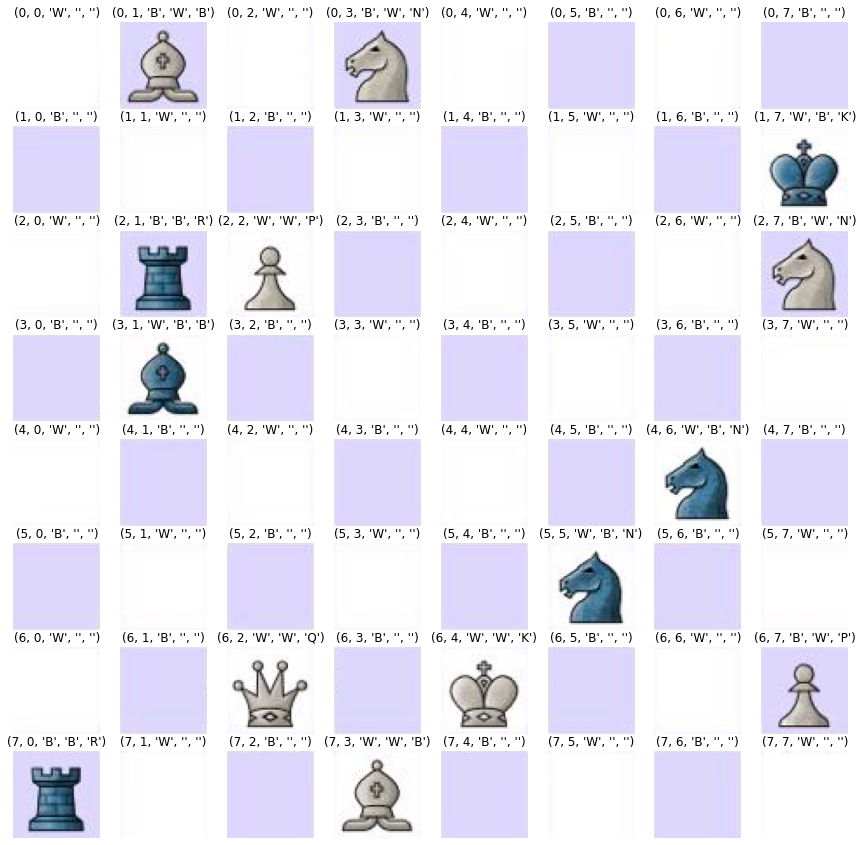

In [7]:
plt.figure(figsize=(15, 15))
for tile in make_data(im, label):
    plt.subplot(8,8,tile.row * 8 + tile.column + 1)
    plt.title(f'{tile[1:]}')
    plt.imshow(tile.image)
    plt.axis('off')

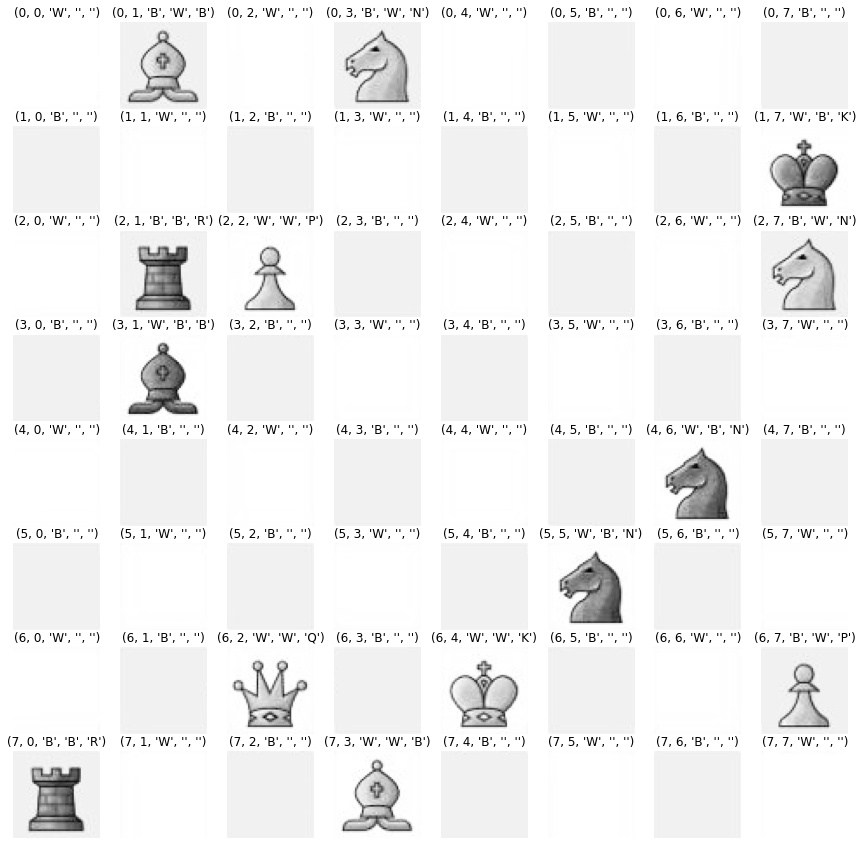

In [8]:
plt.figure(figsize=(15, 15))
for tile in make_data(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), label):
    plt.subplot(8,8,tile.row * 8 + tile.column + 1)
    plt.title(f'{tile[1:]}')
    plt.imshow(tile.image, cmap='Greys_r', vmin=0, vmax=255)
    plt.axis('off')

# GNB for basic classification over all tiles

## Use a GNB classifier to predict 7, 14, 28 classes
7 possible fillings for a board,
14 possible fillings for a board including piece color
28 possible fillings for a board including background

This method is quite naive as it leaves a lot of information that we could leverage out of the solution. For example, the model doesnt know what other pieces from the same board looks like, and doesnt know that there are always exactly 2 kings on a board.

In [82]:
%%time
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

def split_batched_dataset(batch):
    for X, Y in batch:
        batch_x = []
        batch_y = []
        for x, y in zip(X, Y):
            split = make_data(x, y)
            batch_x.extend([t.image for t in split])
            batch_y.extend([t.piece_label for t in split])
        
        # balance the dataset
        
        # frequencies
        freqs = Counter(batch_y)
        min_freq = min(freqs.values())
        # probability of keeping
        probs = {i: min_freq / freqs[i] for i in freqs}
        # random numbers
        randn = np.random.rand(len(batch_x))
        needed_num = np.array(op.itemgetter(*batch_y)(probs))
        bool_idx = needed_num >= randn
    
        yield np.array(batch_x).reshape(len(batch_x), -1)[bool_idx], np.array(batch_y)[bool_idx]

CPU times: user 24 µs, sys: 2 µs, total: 26 µs
Wall time: 28.6 µs


In [83]:
%%time

ssize_train = 10000  # dont do the whole dataset for time reasons
ssize_test = 5000
im_size = (400//2, 400//2)

# train
for X, Y in split_batched_dataset(batched_load(
    test=False, count=ssize_train, color=False, dsize=im_size
)):
    gnb.partial_fit(X, Y, classes=['', *'PNBRQK'])

CPU times: user 22 s, sys: 814 ms, total: 22.8 s
Wall time: 24 s


In [84]:
%%time
from collections import Counter
import operator as op
# test
preds = []
trues = []
for X, Y in split_batched_dataset(batched_load(test=True, count=ssize_test, color=False, dsize=im_size)):
    # balance the dataset
    # frequencies
    freqs = Counter(Y)
    min_freq = min(freqs.values())
    # probability of keeping
    probs = {i: min_freq / freqs[i] for i in freqs}
    # random numbers
    randn = np.random.rand(len(X))
    needed_num = np.array(op.itemgetter(*Y)(probs))
    bool_idx = needed_num >= randn
    
    
    preds.extend(gnb.predict(X[bool_idx]))
    trues.extend(Y[bool_idx])

CPU times: user 5.78 s, sys: 185 ms, total: 5.96 s
Wall time: 6.4 s


Achieved accuracy of 49.43%


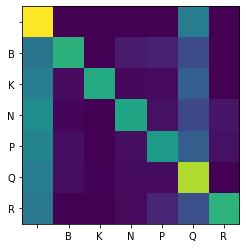

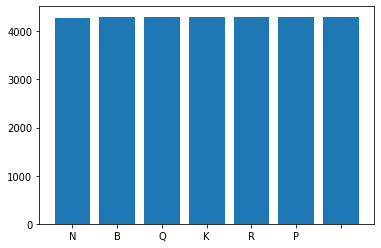

In [85]:
acc = np.mean(np.array(preds) == np.array(trues)) * 100
print(f'Achieved accuracy of {acc:.2f}%')
plt.imshow(confusion_matrix(trues, preds))
plt.xticks(range(len(gnb.classes_)), gnb.classes_)
plt.yticks(range(len(gnb.classes_)), gnb.classes_)
freqs = Counter(trues)
freqs[' '] = freqs['']
del freqs['']
plt.show()
plt.bar(freqs.keys(), freqs.values())
plt.show()

### GNB on dataset (chunk by chunk)

In [11]:
datX = []
datY = []
for x, y in zip(X, Y):
    split = make_data(x, y)
    datX.extend([t.image for t in split])
    datY.extend([t.piece_label for t in split])

In [12]:
model_X = np.array(datX).reshape(640000, -1)
model_Y = np.array([' ' if d == '' else d for d in datY])
classes = list(set(model_Y))

In [12]:
# Fit model chunk by chunk on dataset
chunksize = 5000
n = model_X.shape[0]
gnb = GaussianNB()
for c in np.arange(0, n - chunksize + 1, chunksize, dtype=int):
    end = min(n-1, chunksize + c)
    gnb.partial_fit(model_X[c: end], model_Y[c: end], classes=classes)
    print(f'fitted chunk {c/chunksize} / {n / chunksize * 100} : {c / n:.2f}%', end='\r')

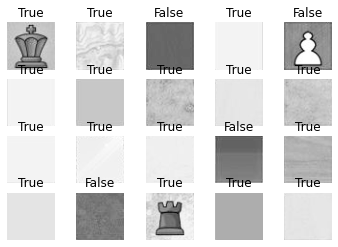

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [13]:
show_idx = np.random.choice(640000, 20, replace=False)

ims = model_X[show_idx]
preds = gnb.predict(ims)
trues = model_Y[show_idx]

for i, (im, pred, true) in enumerate(zip(ims, preds, trues)):
    plt.subplot(4, 5, i+1)
    plt.imshow(im.reshape(50, 50), cmap='Greys_r', vmin=0, vmax=255)
    plt.axis('off')
    plt.title(f'{pred == true}')
plt.show()

preds = []
for c in np.arange(0, n - chunksize + 1, chunksize, dtype=int):
    end = min(n-1, chunksize + c)
    preds.extend(gnb.predict(model_X[c: end]))
    


In [17]:
print(f'accuracy={np.mean(np.array(preds) == model_Y[:-1])}')

accuracy=0.7297386402166254


# PCA for image backgrounds / piece color

## Try PCA on individual boards
Here, we try PCA on individual boards to see if it is a viable method for detection and removal of blank spaces by leveraging the knowledge that most (>> half) of the tiles are empty.

In [ ]:
from sklearn.decomposition import PCA
import operator as op

n_components = 28  # 28 possible tiles, just a guess at what may be a good value

dat_idx = np.random.choice(80000, size=15, replace=False)

# Load black and white
X, Y = load_dataset(idxs=dat_idx, color=False)
Xcol, _ = load_dataset(idxs=dat_idx, color=True)

for xcol, x, y in zip(Xcol, X, Y):
    dat = make_data(x, y)
    pca = PCA()
    pca.fit([d.image.reshape(-1) for d in dat])
    plt.figure(figsize=(5, 10))
    for i, component in enumerate(pca.components_[:10]):
        plt.subplot(6, 4, i+1)
        plt.imshow(component.reshape(50, 50), cmap='Greys_r')
        plt.axis('off')
    plt.subplot(6, 4, 11)
    plt.imshow(split_chessboard(xcol)[0, 0])
    plt.axis('off')
    plt.subplot(6, 4, 12)
    plt.imshow(split_chessboard(xcol)[0, 1])
    plt.axis('off')
    plt.show()

In [ ]:
trans = pca.transform(list(map(lambda x: x.image.flatten(), data)))
plt.scatter(*trans.T[:2], alpha=0.1)

In [ ]:
prev = None
ims = []
for tile in data:
    if (tile.row, tile.column) in [(7, 3), (0, 1)]:
        plt.subplot(131)
        plt.title(tile[1:])
        plt.imshow(tile.image)
        trans = pca.transform(tile.image.flatten().reshape(1, -1))
        trans[0, 1:] = 0
        sub = np.clip(pca.inverse_transform(trans).reshape(50, 50, 3), 0, 255)
        new_im = np.clip(tile.image - sub, 0, 255)
        print(np.max(sub), np.min(sub))
        print(np.max(tile.image), np.min(tile.image))
        print(np.max(new_im), np.min(new_im))
        plt.subplot(132)
        plt.imshow(new_im)
        #plt.imshow(new_im.astype(np.uint8))
        plt.subplot(133)
        ims.append(new_im)
        plt.show()

In [ ]:
plt.imshow(ims[0] - ims[1])